In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [5]:
with open("cleaned/data_table_for_daily_case_trends__the_united_states.csv", "r", encoding="utf-8") as f:
    data = f.read()

data = [row.split(',') for row in  data.split("\n")]

# value = [int(each[1]) for each in data]
value = [float(each[2]) for each in data[1:]]

train  = value[:-100]
test = value[-100:]


# 设置序列数据的时间跨度，seq=7, 指使用过去七天的数据来预测明天的数据
# 注意，这并不是说LSTM每次都只利用到7天的历史数据进行预测，而是7天的显式数据+所有已输入的数据产生的隐式信息（只是隐式信息具有离当前预测距离越远，信息量越弱的特点，详情看下行链接）
# https://www.jianshu.com/p/6815da2d413d 关于RNN的长距离依赖问题，看下这个链接，LSTM比RNN在这方面强很多，但问题仍然存在。


seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(train) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

# 对数据进行缩放有利于训练的收敛，但更好的方式是进行归一化处理；在当前应用上，这几种操作对结果不会造成太大影响，可以作为以后的练习。
# 关于归一化的作用，可以参考这个帖子：https://www.cnblogs.com/LBSer/p/4440590.html

train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)


# 测试集构造

t_x = []
t_y = []

for i in range(len(test) - seq):
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [7]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [8]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))
        if test_loss < 20000:
          # 保存整个网络
          torch.save(model, 'demo') 
          # 保存网络中的参数, 速度快，占空间少
          torch.save(model.state_dict(),'demo')
          break


epoch:20, loss:8753.35546875, test_loss: 54361.8828125
epoch:40, loss:8481.2431640625, test_loss: 53784.5703125
epoch:60, loss:7900.73681640625, test_loss: 52448.41796875
epoch:80, loss:6861.42138671875, test_loss: 49901.33203125
epoch:100, loss:5924.95654296875, test_loss: 47362.59765625
epoch:120, loss:5319.62646484375, test_loss: 45545.45703125
epoch:140, loss:4876.63427734375, test_loss: 44291.43359375
epoch:160, loss:4486.94091796875, test_loss: 43104.9921875
epoch:180, loss:4175.01220703125, test_loss: 42125.66015625
epoch:200, loss:3904.842529296875, test_loss: 41255.234375
epoch:220, loss:3664.917724609375, test_loss: 40466.00390625
epoch:240, loss:3449.28369140625, test_loss: 39741.8359375
epoch:260, loss:3250.947021484375, test_loss: 39053.484375
epoch:280, loss:3047.747802734375, test_loss: 38350.51953125
epoch:300, loss:2878.12890625, test_loss: 37759.41015625
epoch:320, loss:2719.422607421875, test_loss: 37200.6875
epoch:340, loss:2570.322265625, test_loss: 36669.13671875


使用正确数据作为输入进行预测

MSE: 21070825000.0


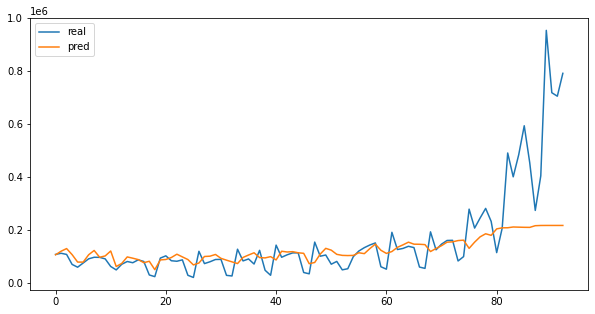

In [9]:
model.eval()

test_pre = list((model(test_x).data.reshape(-1))*1000)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(test_y*1000, test_pre))

plt.figure(figsize=(10,5))

# 真实数据
plt.plot(test_y*1000, label="real")


# 预测结果
plt.plot(test_pre, label="pred")

# 模型预测的走势
plt.legend(loc='best')





lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)           



使用预测数据作为输入递归预测未来趋势

In [10]:
result = []

result.append(test_x[0][0][0])
result.append(test_x[0][1][0])
result.append(test_x[0][2][0])
result.append(test_x[0][3][0])
result.append(test_x[0][4][0])
result.append(test_x[0][5][0])
result.append(test_x[0][6][0])


print(result)

[tensor(116.4070), tensor(122.5730), tensor(120.1320), tensor(81.4250), tensor(68.3630), tensor(87.5720), tensor(104.9200)]


In [11]:
# 预测未来10天的数据，
for i in range(30):
  result.append(model(torch.tensor(result[i:i+7]).reshape(1,7,1)))



print(len(result)) 
print(len(test_y)) 

result = [i * 1000 for i in result]
print(result)

print("MSE:", mean_squared_error(test_y[0:30]*1000, result[7:]))


plt.figure(figsize=(10,5))

# 真实数据
plt.plot(test_y*1000, label="real")


# 预测结果
plt.plot(result[7:], label="pred")

# 模型预测的走势
plt.legend(loc='best')


37
93
[tensor(116407.), tensor(122573.), tensor(120132.), tensor(81425.), tensor(68363.), tensor(87572.), tensor(104920.), tensor([[106341.1016]], grad_fn=<MulBackward0>), tensor([[119377.6250]], grad_fn=<MulBackward0>), tensor([[132069.8594]], grad_fn=<MulBackward0>), tensor([[120828.7656]], grad_fn=<MulBackward0>), tensor([[117316.9922]], grad_fn=<MulBackward0>), tensor([[104397.3359]], grad_fn=<MulBackward0>), tensor([[92677.0078]], grad_fn=<MulBackward0>), tensor([[124763.6328]], grad_fn=<MulBackward0>), tensor([[114583.2734]], grad_fn=<MulBackward0>), tensor([[123715.9609]], grad_fn=<MulBackward0>), tensor([[119880.4766]], grad_fn=<MulBackward0>), tensor([[98202.1953]], grad_fn=<MulBackward0>), tensor([[112464.5859]], grad_fn=<MulBackward0>), tensor([[100178.3516]], grad_fn=<MulBackward0>), tensor([[102702.5156]], grad_fn=<MulBackward0>), tensor([[104081.4062]], grad_fn=<MulBackward0>), tensor([[114010.8906]], grad_fn=<MulBackward0>), tensor([[116127.7656]], grad_fn=<MulBackward0>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)    


真实环境下，预测第11个月的数据：
model = lstm
model([...*6,300]) = y_301
model([...*5, 300, y_301]) = y_302
       ....


预测的越远，效果越差


如果数据有固定的模式，则效果不会变的特别差

黑天鹅




